

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking по определению того, курит человек или нет с помощью биосигналов.


# Step 1 - TRAIN

Обучение пайплайна

    

*   Загрузим данные https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking
*   Соберем пайплайн с простейшим препроцессингом на текстовых данных
*   Обучим несколько моделей и выберем лучшую
*   Обучим модель и сохраним на диск предобученный пайплайн

    
    


In [40]:
import pandas as pd
import dill
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import f1_score

#working with text
from sklearn.feature_extraction.text import TfidfVectorizer

#normalizing data
from sklearn.preprocessing import StandardScaler

#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score,recall_score

#imputer
from sklearn.impute import SimpleImputer

import sklearn.datasets

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузим данные

Ссылка на kaggle: https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking


In [41]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import opendatasets as od

In [43]:
od.download("https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking")

Skipping, found downloaded files in "./body-signal-of-smoking" (use force=True to force download)


In [44]:
df = pd.read_csv("./body-signal-of-smoking/smoking.csv")
df.head(3)

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1


Мы видим ряд колонок

    ID : index
    gender
    age : 5-years gap
    height(cm)
    weight(kg)
    waist(cm) : Waist circumference length
    eyesight(left)
    eyesight(right)
    hearing(left)
    hearing(right)
    systolic : Blood pressure
    relaxation : Blood pressure
    fasting blood sugar
    Cholesterol : total
    triglyceride
    HDL : cholesterol type
    LDL : cholesterol type
    hemoglobin
    Urine protein
    serum creatinine
    AST : glutamic oxaloacetic transaminase type
    ALT : glutamic oxaloacetic transaminase type
    Gtp : γ-GTP
    oral : Oral Examination status
    dental caries
    tartar : tartar status
    smoking


Есть как категориальные, так и вещественные признаки.

Посмотрим на распределение классов:

In [45]:
df['smoking'].value_counts()

0    35237
1    20455
Name: smoking, dtype: int64

In [46]:
df = df.rename(columns={"height(cm)": "height", "weight(kg)": "weight", "waist(cm)": "waist", "eyesight(left)": "eyesight_left", "eyesight(right)": "eyesight_right",
                   "hearing(left)": "hearing_left", "hearing(right)": "hearing_right", "fasting blood sugar": "fasting_blood_sugar",
                   "Cholesterol": "cholesterol", "HDL": "hdl", "LDL": "ldl", "Urine protein": "urine_protein", 
                   "serum creatinine": "serum_creatinine", "AST": "ast", "ALT": "alt", "Gtp": "gtp", "dental caries": "dental_caries"})

Хорошее распределение (1 к 1,5)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [47]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['smoking'], random_state=0)

# save test
X_test.to_csv("/content/drive/MyDrive/X_test.csv", index=None)
y_test.to_csv("/content/drive/MyDrive/y_test.csv", index=None)

# save train
X_train.to_csv("/content/drive/MyDrive/X_train.csv", index=None)
y_train.to_csv("/content/drive/MyDrive/y_train.csv", index=None)

*   Категориальные признаки закодируем с помощью OneHotEncoding
*   Вещественные оставим пока как есть 



In [48]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

Зададим списки признаков

In [49]:
categorical_columns = ['gender', 'oral', 'tartar', 'dental_caries']
continuous_columns = ['age', 'height', 'weight', 'waist', 'eyesight_left', 'eyesight_right', 'hearing_left', 'hearing_right', 'systolic', 'relaxation', 'fasting_blood_sugar', 
                      'cholesterol', 'triglyceride', 'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast', 'alt', 'gtp']


Теперь нам нужно под каждый признак создать трансформер и объединить их в список.


In [50]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    
    final_transformers.append((cont_col, cont_transformer))



Объединим все это в единый пайплайн


In [51]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Определим какая модель подойдет лучше всего для нашей задачи

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [53]:
def training(classifier, classifier_name):
    from sklearn.metrics import roc_auc_score

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    # расчтаем метрики
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc_score = roc_auc_score(y_test, y_score)
    ix = np.argmax(fscore)
    cm = confusion_matrix(y_test, y_score>thresholds[ix])

    # мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
    font = {'size' : 15}
    plt.rc('font', **font)
    plt.figure(figsize=(6, 4))
    plot_confusion_matrix(cm, classes=['NonChurn', 'Churn'], title=f'Confusion matrix for {classifier_name}')
    # plt.savefig("conf_matrix.png")
    plt.show()
 
    return [round(i, 3) for i in [thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score, cm[1,1], cm[0,1], cm[0,0], cm[1,0]]]


In [54]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


Confusion matrix, without normalization
[[5689 3176]
 [ 552 4506]]


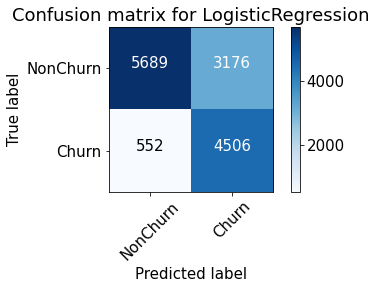

Confusion matrix, without normalization
[[6902 1963]
 [ 488 4570]]


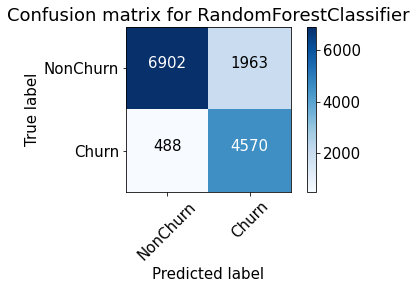

Confusion matrix, without normalization
[[6179 2686]
 [ 723 4335]]


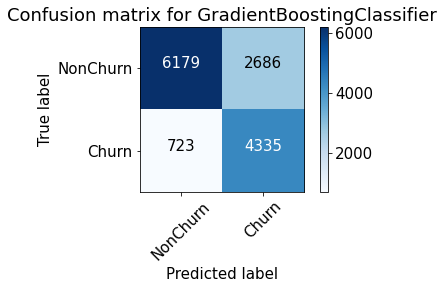

Confusion matrix, without normalization
[[6255 2610]
 [ 769 4289]]


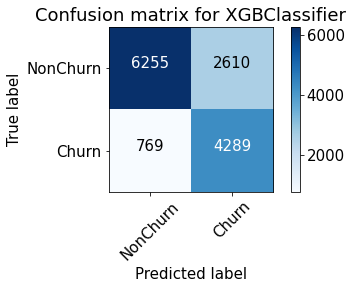

In [56]:
results = pd.DataFrame([
    training(classifier=Pipeline([('features', feats), ('classifier', LogisticRegression(random_state=42))]), classifier_name='LogisticRegression'),
    training(classifier=Pipeline([('features', feats), ('classifier', RandomForestClassifier(random_state=42))]), classifier_name='RandomForestClassifier'),
    training(classifier=Pipeline([('features', feats), ('classifier', GradientBoostingClassifier(random_state=42))]), classifier_name='GradientBoostingClassifier'),
    training(classifier=Pipeline([('features', feats), ('classifier', xgb.XGBClassifier(random_state=42, 
                                                                                        use_label_encoder=False, 
                                                                                        eval_metric='logloss'))]), classifier_name='XGBClassifier') 
], columns=['Best Threshold', 'F', 'Precision', 'Recall', 'ROC AUC', 'TP', 'FP', 'TN', 'FN'])

results['models'] = ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier', 'XGBClassifier']
results = results.set_index('models')


In [57]:
results

,Best Threshold,F,Precision,Recall,ROC AUC,TP,FP,TN,FN
models,,,,,,,,,
LogisticRegression,0.403,0.707,0.587,0.891,0.832,4506,3176,5689,552
RandomForestClassifier,0.410,0.789,0.695,0.913,0.916,4570,1963,6902,488
GradientBoostingClassifier,0.415,0.718,0.617,0.857,0.849,4335,2686,6179,723
XGBClassifier,0.431,0.718,0.622,0.848,0.849,4289,2610,6255,769


Наиболее подходщая метрика это ROC AUC. Т.о. лучшая модель - RandomForestClassifier.

Добавим классификатор RandomForestClassifier

In [58]:
%%time

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier()),
])

pipeline.fit(X_train, y_train)

CPU times: user 12.3 s, sys: 43.2 ms, total: 12.3 s
Wall time: 14.1 s


Посмотрим, как выглядит наш pipeline

In [59]:
pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='gender'))])),
                                                ('oral',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='oral')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='oral'))])),
                                                ('tartar',
                                                 Pipeline(steps=[('selector',
                          

Сохраним модель (пайплайн)

In [60]:
with open("pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)

# Step 2 - PREDICT

### Проверка работоспособности и качества пайплайна

Здесь мы еще не запускаем никакое API, а загружаем модель (pipeline) напрямую и проверяем на отложенной (тестовой) выборке

In [61]:
X_test.head(3)

,ID,gender,age,height,weight,waist,eyesight_left,eyesight_right,hearing_left,hearing_right,...,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,oral,dental_caries,tartar,smoking
35359,44185,M,60,155,55,77.0,1.0,1.0,1.0,1.0,...,14.7,1.0,0.9,24.0,14.0,11.0,Y,0,Y,0
22183,27703,M,40,175,85,90.7,1.2,1.0,1.0,1.0,...,16.9,1.0,1.2,43.0,64.0,139.0,Y,0,Y,1
32552,40647,M,25,170,80,94.0,1.5,1.5,1.0,1.0,...,14.6,1.0,0.9,35.0,48.0,30.0,Y,0,N,0


In [62]:
with open('pipeline.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [63]:
preds = pipeline.predict_proba(X_test)[:, 1]

pred_df = pd.DataFrame({'preds': preds})
pred_df.to_csv("test_predictions.csv", index=None)

In [64]:
preds[:10]

array([0.48, 0.8 , 0.43, 0.6 , 0.73, 0.01, 0.06, 0.19, 0.  , 0.03])

In [65]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.43, F-Score=0.789, Precision=0.706, Recall=0.895


# Step 3 - FLASK

## Flask

Тут будет сервис для обработки запросов на Flask

Google Colab предоставляет виртуальную машину, поэтому мы не можем получить доступ к локальному хосту, как это делаем на нашем локальном компьютере при запуске локального веб-сервера. Что мы можем сделать, так это предоставить его общедоступному URL-адресу с помощью ngrok.

https://medium.com/@kshitijvijay271199/flask-on-google-colab-f6525986797b


In [66]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify
import pandas as pd

In [68]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
!tar -xvf /content/ngrok-stable-linux-amd64.tgz
!./ngrok authtoken 25vEpcJ5Ih4vlUp4thEZ9sEA6ZU_3Bnu17gKacRXhF6hLeefc
!./ngrok http 80

--2022-06-01 09:26:25--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 18.205.222.128, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13770165 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.tgz.1’

k-stable-linux-amd6   5%[>                   ] 766.22K   176KB/s    eta 98s    ^C
ngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [69]:
import pandas as pd
import dill

### **Создаем сервис для обработки запросов к модели**


In [70]:
# Загружаем обученные модели
with open('pipeline.dill', 'rb') as in_strm:
    model = dill.load(in_strm)

Запустить сервис и не глушить его, пока работаем 

In [71]:
# Обработчики и запуск Flask
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run


@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"


@app.route('/predict', methods=['POST'])
def predict():
    data = {"success": False}

    # ensure an image was properly uploaded to our endpoint
    ID, gender, age, height, weight, waist, eyesight_left, eyesight_right, hearing_left, hearing_right, systolic, relaxation, fasting_blood_sugar, cholesterol, triglyceride, hdl, ldl, hemoglobin, urine_protein, serum_creatinine, ast, alt, gtp, oral, dental_caries, tartar = "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", ""

    request_json = request.get_json()

    if request_json["ID"]:
        ID = request_json['ID']
    
    if request_json["gender"]:
        gender = request_json['gender']
   
    if request_json["age"]:
        age = request_json['age']
                
    if request_json["height"]:
        height = request_json['height']

    if request_json["weight"]:
        weight = request_json['weight']

    if request_json["waist"]:
        waist = request_json['waist']

    if request_json["eyesight_left"]:
        eyesight_left = request_json['eyesight_left']

    if request_json["eyesight_right"]:
        eyesight_right = request_json['eyesight_right']

    if request_json["hearing_left"]:
        hearing_left = request_json['hearing_left']

    if request_json["hearing_right"]:
        hearing_right = request_json['hearing_right']

    if request_json["systolic"]:
        systolic = request_json['systolic']

    if request_json["relaxation"]:
        relaxation = request_json['relaxation']

    if request_json["fasting_blood_sugar"]:
        fasting_blood_sugar = request_json['fasting_blood_sugar']

    if request_json["cholesterol"]:
        cholesterol = request_json['cholesterol']

    if request_json["triglyceride"]:
        triglyceride = request_json['triglyceride']

    if request_json["hdl"]:
        hdl = request_json['hdl']

    if request_json["ldl"]:
        ldl = request_json['ldl']

    if request_json["hemoglobin"]:
        hemoglobin = request_json['hemoglobin']

    if request_json["urine_protein"]:
        urine_protein = request_json['urine_protein']

    if request_json["serum_creatinine"]:
        serum_creatinine = request_json['serum_creatinine']

    if request_json["ast"]:
        ast = request_json['ast']

    if request_json["alt"]:
        alt = request_json['alt']                

    if request_json["gtp"]:
        gtp = request_json['gtp']       

    if request_json["oral"]:
        oral = request_json['oral']

    if request_json["tartar"]:
        tartar = request_json['tartar']

    if request_json["dental_caries"]:
        dental_caries = request_json['dental_caries'] 
    
    df = pd.DataFrame({"gender": [gender],
                                              "age": [age],
                                              "height": [height],
                                              "weight": [weight],
                                              "waist": [waist],
                                              "eyesight_left": [eyesight_left],
                                              "eyesight_right": [eyesight_right],
                                              "hearing_left": [hearing_left],
                                              "hearing_right": [hearing_right],
                                              "systolic": [systolic],
                                              "relaxation": [relaxation],
                                              "fasting_blood_sugar": [fasting_blood_sugar],
                                              "cholesterol": [cholesterol],
                                              "triglyceride": [triglyceride],
                                              "hdl": [hdl],
                                              "ldl": [ldl],
                                              "hemoglobin": [hemoglobin],
                                              "urine_protein": [urine_protein],
                                              "serum_creatinine": [serum_creatinine],
                                              "ast": [ast],
                                              "alt": [alt],
                                              "gtp": [gtp],
                                              "oral": [oral],
                                              "tartar": [tartar],
                                              "dental_caries": [dental_caries]})
    preds = model.predict_proba(df)
    

    data["predictions"] = preds[:, 1][0]
    data["ID"] = ID
        # indicate that the request was a success
    data["success"] = True
    # print('OK')

        # return the data dictionary as a JSON response
    return jsonify(data)

        # return the data dictionary as a JSON response
    return jsonify(data)


if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://7fa2-35-236-155-186.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [01/Jun/2022 09:27:25] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:27] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:28] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:28] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:29] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:29] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:29] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:30] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:30] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:31] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:31] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:31] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:32] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:32] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2022 09:27:32] "POST /pred

Тестовый клиент

In [74]:
# Пример данных
id, gender, age, height, weight, waist, eyesight_left, eyesight_right, hearing_left, hearing_right, systolic, relaxation, fasting_blood_sugar, cholesterol, triglyceride, hdl, ldl, hemoglobin, urine_protein, serum_creatinine, ast, alt, gtp, oral, dental_caries, tartar = (1,"F",40,155,60,81.3,1.2,1,1,1,114,73,94,215,82,73,126,12.9,1,0.7,18,19,27,"Y",0,"Y")
body = {
        'ID': id,
        'gender': gender,
        'age': age,
        'height': height,
        'weight': weight,
        'waist': waist,
        'eyesight_left': eyesight_left,
        'eyesight_right': eyesight_right,
        'hearing_left': hearing_left,
        'hearing_right': hearing_right,
        'systolic': systolic,
        'relaxation': relaxation,
        'fasting_blood_sugar': fasting_blood_sugar,
        'cholesterol': cholesterol,
        'triglyceride': triglyceride,
        'hdl': hdl,
        'ldl': ldl,
        'hemoglobin': hemoglobin,
        'urine_protein': urine_protein,
        'serum_creatinine': serum_creatinine,
        'ast': ast,
        'alt': alt,
        'gtp': gtp,
        'oral': oral,
        'dental_caries': dental_caries,
        'tartar': tartar
      }

In [75]:
with app.test_client() as t:
    response = t.post('/predict', json=body)
    json_data = response.get_json()

json_data

{'ID': 1, 'predictions': 0.05, 'success': True}